<a href="https://colab.research.google.com/github/csisyoon-hui/Data-Analysis-with-Open-Source/blob/main/%EC%98%A4%ED%94%88%EC%86%8C%EC%8A%A4_%EB%8D%B0%EC%9D%B4%ED%84%B0_%EB%B6%84%EC%84%9D_14%EA%B0%95_mine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 14강 비정형 데이터 분석 : 패션 사진 데이터 활용

### 목표

- 비정형 데이터를 인공지능 모델로 분석하여 실무에서 활용 가능한 보고서 형태로 가공

- 패션 트렌드라는 구체적인 주제를 통해, 비정형 데이터 분석의 실질적인 활용 방안을 경험하고자 함


### 분석 프로세스 개요

1. 데이터 수집
  - requests를 이용한 RSS 데이터 수집
  - lxml을 이용한 XML 파싱
  - 이미지 데이터 추출
2. VLM을 이용한 이미지 분석
  - 프롬프트를 이용한 이미지 필터링
  - 프롬프트를 이용한 스타일 분석
3. LLM을 이용한 키워드 분석 및 보고서 작성
  - 텍스트 전처리
  - 색상 및 스타일 키워드 추출
  - 워드 클라우드 분석
  - 보고서 작성

# 주의 : 런타임 GPU 로 설정 필요

In [1]:
# 4bit VLM 처리를 위한 bitsandbytes 설치
# LLM 처리를 위한 VLLM 설치 (오래걸리는 작업(>5분)이므로 미리 실행!)
!pip install bitsandbytes==0.45.3 vllm==0.7.3 transformers==4.48.2
# 필요 시 세션 재시작

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.2 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of opencv-python-headless to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 45.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.5/96.5 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.6/71.6 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.0/111.0 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.6/87.6 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 MB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 906.4/906

In [1]:
# 한글 처리를 위한 matplotlib 설정 (1)

!sudo apt-get install -y fonts-nanum
!sudo fc-cache –fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 41 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 1s (12.9 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 121713 files and direc

- 런타임 -> 세션 다시 시작

In [1]:
# 한글 처리를 위한 matplotlib 설정 (2)

import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')

# 1. 데이터 수집 및 전처리

## 14-1 RSS 피드에서 이미지 URL 추출

In [2]:
import requests
from lxml import etree
from lxml.html import fromstring
import pandas as pd

def extract_unique_images(rss_url):
    ## 주어진 RSS 피드 URL에서 고유한 이미지 URL들을 추출하는 함수 정의
    try:
        ## requests 라이브러리를 사용하여 RSS 피드 URL로부터 내용을 가져옴
        response = requests.get(rss_url)
        ## 가져온 XML 응답 내용을 lxml의 etree.fromstring으로 파싱하여 XML 트리 root를 생성 - 나~!
        root = etree.fromstring(response.content)
        image_urls = set()

        ## XML 트리에서 모든 'item' 태그를 XPath를 사용하여 순회
        for item in root.xpath('//item'):
            description = item.find('description')
            if description is not None and description.text:
                ## description의 텍스트 내용을 lxml.html.fromstring으로 파싱하여 HTML 트리를 생성 - 나~!
                html_tree = fromstring(description.text)
                ## HTML 트리에서 첫 번째 <img> 태그의 'src' 속성 값을 XPath를 사용하여 추출 - 나~!
                img_url = html_tree.xpath('string(//img/@src)')
                if img_url:
                    image_urls.add(img_url)

        return list(image_urls)

    except Exception as e:
        ## 오류 발생 시 오류 메시지를 출력하고 빈 리스트를 반환
        print(f"Error occurred: {e}")
        return []

rss_url = "https://glltn.com/feed/"
## extract_unique_images 함수를 호출하여 고유한 이미지 URL들을 추출
unique_images = extract_unique_images(rss_url)

## 추출된 이미지 URL 리스트를 사용하여 'image'라는 열을 가진 pandas DataFrame을 생성
df = pd.DataFrame(unique_images, columns=["image"])

In [4]:
df

,image
0,https://glltn.com/wp-content/blogs.dir/1/files...
1,https://glltn.com/wp-content/blogs.dir/1/files...
2,https://glltn.com/wp-content/blogs.dir/1/files...
3,https://glltn.com/wp-content/blogs.dir/1/files...
4,https://glltn.com/wp-content/blogs.dir/1/files...
5,https://glltn.com/wp-content/blogs.dir/1/files...
6,https://glltn.com/wp-content/blogs.dir/1/files...
7,https://glltn.com/wp-content/blogs.dir/1/files...
8,https://glltn.com/wp-content/blogs.dir/1/files...
9,https://glltn.com/wp-content/blogs.dir/1/files...


## 14-2 수집 데이터 확인

In [5]:
from IPython.display import display, HTML

def path_to_image_html(path):
    ## 이미지 경로를 HTML img 태그로 변환하는 함수
    return f'<img src="{path}" width="300" />'

## DataFrame의 스타일을 설정하여 이미지 너비를 300px로 지정
df.style.set_table_styles([{'selector': 'img', 'props': 'width: 300px;'}])

## DataFrame을 HTML로 변환하여 출력. 이미지 열은 path_to_image_html 함수로 포맷팅
display(HTML(df.to_html(escape=False, formatters=dict(**{'image': path_to_image_html}))))

,image
0,
1,
2,
3,
4,
5,
6,
7,
8,
9,


## 2. VLM을 이용한 이미지 분석

## 14-3 VLM 모델 로드

In [6]:
import torch
from PIL import Image
from transformers import AutoModel, AutoTokenizer

## 'openbmb/MiniCPM-V-2_6-int4' 모델을 사전 훈련된 가중치와 함께 로드
## trust_remote_code=True는 허브에서 사용자 정의 코드를 실행할 수 있도록 허용
model = AutoModel.from_pretrained('openbmb/MiniCPM-V-2_6-int4', trust_remote_code=True)
## 로드된 모델에 해당하는 토크나이저를 로드
tokenizer = AutoTokenizer.from_pretrained('openbmb/MiniCPM-V-2_6-int4', trust_remote_code=True)
## 모델을 평가 모드로 설정 (드롭아웃 등 훈련 시에만 필요한 기능 비활성화)
model.eval()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

configuration_minicpm.py: 0.00B [00:00, ?B/s]

modeling_navit_siglip.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/openbmb/MiniCPM-V-2_6-int4:
- modeling_navit_siglip.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/openbmb/MiniCPM-V-2_6-int4:
- configuration_minicpm.py
- modeling_navit_siglip.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_minicpmv.py: 0.00B [00:00, ?B/s]

resampler.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/openbmb/MiniCPM-V-2_6-int4:
- resampler.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/openbmb/MiniCPM-V-2_6-int4:
- modeling_minicpmv.py
- resampler.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
Unused kwargs: ['_load_in_4bit', '_load_in_8bit', 'quant_method']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.
`low_cpu_mem_usage` was None, now default to True since model is quantized.


model.safetensors.index.json: 0.00B [00:00, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.45G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/1.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/121 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenization_minicpmv_fast.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/openbmb/MiniCPM-V-2_6-int4:
- tokenization_minicpmv_fast.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

MiniCPMV(
  (llm): Qwen2ForCausalLM(
    (model): Qwen2Model(
      (embed_tokens): Embedding(151666, 3584)
      (layers): ModuleList(
        (0-27): 28 x Qwen2DecoderLayer(
          (self_attn): Qwen2Attention(
            (q_proj): Linear4bit(in_features=3584, out_features=3584, bias=True)
            (k_proj): Linear4bit(in_features=3584, out_features=512, bias=True)
            (v_proj): Linear4bit(in_features=3584, out_features=512, bias=True)
            (o_proj): Linear4bit(in_features=3584, out_features=3584, bias=False)
          )
          (mlp): Qwen2MLP(
            (gate_proj): Linear4bit(in_features=3584, out_features=18944, bias=False)
            (up_proj): Linear4bit(in_features=3584, out_features=18944, bias=False)
            (down_proj): Linear4bit(in_features=18944, out_features=3584, bias=False)
            (act_fn): SiLU()
          )
          (input_layernorm): Qwen2RMSNorm((3584,), eps=1e-06)
          (post_attention_layernorm): Qwen2RMSNorm((3584,), eps=

![](https://farm3.staticflickr.com/2677/4434956914_6e95a22940_z.jpg)

## 14-4 이미지 질문 응답 예시

In [7]:
from transformers import set_seed

## 재현성을 위해 시드(seed)를 42로 설정
set_seed(42)
## 예시 이미지 URL 정의
image_url = 'https://farm3.staticflickr.com/2677/4434956914_6e95a22940_z.jpg'
## requests로 이미지 다운로드 후 PIL Image 객체로 열고 RGB 형식으로 변환
image = Image.open(requests.get(image_url, stream=True).raw).convert('RGB')
## 이미지에 대한 질문 정의
question = 'how many cats in the photo?'
## 모델 입력 형식에 맞춰 메시지 구성 (이미지와 질문 포함)
msgs = [{'role': 'user', 'content': [image, question]}]
## 모델의 chat 함수를 호출하여 이미지와 질문에 대한 응답 생성
result = model.chat(image=None, msgs=msgs, tokenizer=tokenizer)
## 모델의 응답 출력
print(result)

preprocessor_config.json:   0%|          | 0.00/714 [00:00<?, ?B/s]

processing_minicpmv.py: 0.00B [00:00, ?B/s]

image_processing_minicpmv.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/openbmb/MiniCPM-V-2_6-int4:
- image_processing_minicpmv.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/openbmb/MiniCPM-V-2_6-int4:
- processing_minicpmv.py
- image_processing_minicpmv.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
/usr/local/lib/python3.12/dist-packages/transformers/models/auto/image_processing_auto.py:590: FutureWarning: The image_processor_class argument is deprecated and will be removed in v4.42. Please use `slow_image_processor_class`, or `fast_image_processor_class` instead
  warnings.warn(
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=

1


In [11]:
set_seed(86)
## 이미지에 대한 질문을 업데이트. 책 표지의 고양이도 포함하도록 요청
question = 'how many cats in the photo? including the books cover.'
## 모델 입력 형식에 맞춰 메시지 구성 (이전에 로드된 이미지와 업데이트된 질문 포함)
msgs = [{'role': 'user', 'content': [image, question]}]
## 모델의 chat 함수를 호출하여 업데이트된 질문에 대한 응답 생성
result = model.chat(image=None, msgs=msgs, tokenizer=tokenizer)
## 모델의 응답 출력
print(result)

2


In [9]:
set_seed(42)
## 이미지에 대한 질문을 'describe the photo'로 설정하여 이미지 내용을 설명하도록 요청
question = 'describe the photo'
## 모델 입력 형식에 맞춰 메시지 구성 (이전에 로드된 이미지와 설명 요청 질문 포함)
msgs = [{'role': 'user', 'content': [image, question]}]
## 모델의 chat 함수를 호출하여 이미지에 대한 설명을 생성
result = model.chat(image=None, msgs=msgs, tokenizer=tokenizer)
## 모델의 응답 (이미지 설명) 출력
print(result)

The photo shows a book titled "why dogs are better than cats" with an image of a cat on the cover, resting its head on a dog's back. To the right side of the frame is a real-life cat, standing and observing the camera, which has a similar striped pattern as the one depicted on the book cover. The setting appears to be indoors, possibly on a wooden surface or floor.


## 14-5 의류 이미지 여부 판단

In [13]:
def is_picture_of_clothing(image_url):
    ## 이미지 URL이 의류 사진인지 판단하는 함수
    # 의류가 포함된 사진인지 확인하는 질문 작성 (영어로)
    question = 'Is this a picture of clothing? Must say yes or no.'
    image = Image.open(requests.get(image_url, stream=True).raw).convert('RGB')
    msgs = [{'role': 'user', 'content': [image, question]}]
    result = model.chat(image=None, msgs=msgs, tokenizer=tokenizer, temperature=0.1)
    print(result)
    ## 응답에 'yes'가 포함되어 있는지 확인하여 True/False 반환
    return 'yes' in result.lower()

## DataFrame의 'image' 열에 함수를 적용하여 'is_clothing' 열에 결과 저장
df['is_clothing'] = df['image'].apply(is_picture_of_clothing)

Yes, this image is of clothing. Specifically, it features a pair of sneakers, which are a type of footwear designed for casual wear and sports activities. Sneakers like these are often made from canvas or leather materials and typically have rubber soles with a pattern that provides traction. The design elements such as the color contrast and the style suggest they could be part of a fashion collection or a specific brand's line.
Yes, this image is of clothing. It features a person modeling a green zip-up hoodie with the word "ARM" printed on it, layered over a blue denim shirt and paired with jeans. The focus on the garment's design elements such as the color, print, and layering suggests that the photograph is meant to showcase the clothing items.
No, this image is not of clothing. It appears to be a book cover or a similar type of printed material with the title "Transcripts of a Sea." The presence of what looks like a seal stamp and the textured background suggest it could be an ar

## 14-6 의류 판단 결과 시각화

In [14]:
display(HTML(df.to_html(escape=False, formatters=dict(**{'image': path_to_image_html}))))

,image,is_clothing
0,,True
1,,True
2,,False
3,,False
4,,False
5,,True
6,,True
7,,True
8,,True
9,,True


## 14-7 의류 이미지 필터링

In [15]:
## 'is_clothing' 열의 값이 True인 행들만 필터링하여 DataFrame을 업데이트 - 나~!
df = df[df['is_clothing']]

In [16]:
display(HTML(df.to_html(escape=False, formatters=dict(**{'image': path_to_image_html}))))

,image,is_clothing
0,,True
1,,True
5,,True
6,,True
7,,True
8,,True
9,,True
10,,True
11,,True


## 14-8 의류 스타일 분석

In [17]:
def describe_style(image_url):
    ## 주어진 이미지 URL의 의류 스타일을 분석하는 함수
    question = 'Analyze the style of the clothes. please let me explain the colors and trend changes'
    image = Image.open(requests.get(image_url, stream=True).raw).convert('RGB')
    msgs = [{'role': 'user', 'content': [image, question]}]
    ## 모델의 chat 함수를 호출하여 이미지에 대한 스타일 분석 응답 생성
    result = model.chat(image=None, msgs=msgs, tokenizer=tokenizer)
    return result

## 필터링된 DataFrame의 'image' 열에 describe_style 함수를 적용
## 결과는 'style'이라는 새로운 열에 저장
df['style'] = df['image'].apply(describe_style)

/tmp/ipython-input-511155451.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['style'] = df['image'].apply(describe_style)


In [18]:
display(HTML(df.to_html(escape=False, formatters=dict(**{'image': path_to_image_html}))))

,image,is_clothing,style
0,,True,"The style of the shoes depicted in the image is reminiscent of classic, casual footwear that has seen a resurgence in popularity. The color scheme of beige or light tan with burgundy accents suggests a nod to vintage fashion trends, where such combinations were often used. This color palette can evoke a sense of nostalgia and timelessness.\n\nIn terms of trend changes, these shoes reflect a preference for retro-inspired designs that have been modernized for contemporary wearers. Such styles are often characterized by their clean lines, minimalistic design, and the use of durable materials like canvas or leather. These elements are indicative of a trend towards timeless pieces that can be easily integrated into various outfits without being overly flashy or trendy.\n\nThe lace-up closure is a classic feature that allows for both comfort and adjustability, catering to a wide range of foot sizes and preferences. Additionally, the presence of a visible logo on the tongue suggests brand recognition, which is a common trait in fashion items that appeal to consumers who value both aesthetics and brand identity.\n\nOverall, the shoes represent a blend of practicality and style that aligns with current fashion sensibilities that favor versatility, comfort, and a touch of retro charm."
1,,True,"The clothing style in the image reflects a casual, yet trendy aesthetic that is popular in contemporary fashion. The green hoodie with ""ARM"" printed on it suggests a relaxed and sporty look, which is often associated with streetwear or urban casual styles. Hoodies are versatile pieces that can be dressed up or down, and this one's muted color makes it suitable for various settings.\n\nUnderneath the hoodie, there is a light blue button-up shirt with a checkered pattern, adding an element of classic style to the outfit. Button-up shirts are timeless pieces that can complement casual wear by introducing a touch of formality. The cuffs of the shirt are visible, indicating that they may have been rolled up, which is a common trend to create a more laid-back appearance.\n\nJeans are another staple in casual fashion, offering durability and comfort. The distressed details on the jeans suggest a preference for trends that embrace imperfection and a worn-in look, which has become a significant part of modern streetwear.\n\nOverall, the combination of these items indicates a blend of comfort and style, with an emphasis on casual wear that could easily transition from day to evening activities. The colors chosen—green, light blue, and denim—are all neutral and complementary, contributing to a cohesive and fashionable ensemble."
5,,True,"The style of the clothes worn by the individuals in the image leans towards a casual, yet thoughtfully curated aesthetic. The use of neutral tones such as beige, grey, and brown suggests a preference for understated elegance that is both timeless and versatile. The cardigan-style tops paired with shorts indicate a relaxed approach to fashion, possibly influenced by streetwear or contemporary minimalist trends.\n\nThe maroon cardigan on the left introduces a pop of color, which adds visual interest without overwhelming the overall simplicity of the outfit. This choice could be seen as a nod to retro influences, where such vibrant colors were popular in past decades but have made a resurgence in modern fashion.\n\nThe clothing appears to be well-fitted, suggesting an attention to detail and quality. The layering of garments, with one piece over another, showcases a practical yet stylish way to adapt to varying temperatures while maintaining a cohesive look.\n\nOverall, the outfits reflect a blend of comfort and style, indicative of a trend-conscious audience that values both functionality and aesthetics. The choice of materials, like what seems to be soft cotton or linen, points towards a preference for natural fibers, which are often associated with breathability and comfort."
6,,True,"The

# 3. LLM을 이용한 키워드 분석 및 보고서 작성

## 14-9 언어 모델(LLM) 로드

In [19]:
from vllm import LLM, SamplingParams

## vLLM 라이브러리를 사용하여 'LGAI-EXAONE/EXAONE-3.5-2.4B-Instruct' 모델을 로드 - 나~!
## gpu_memory_utilization은 GPU 메모리 사용 비율을 0.5로 설정 - 나~!
## max_model_len은 모델이 처리할 수 있는 최대 토큰 길이를 10000으로 설정 - 나~!
llm = LLM(
    model="LGAI-EXAONE/EXAONE-3.5-2.4B-Instruct",
    gpu_memory_utilization=0.5,
    max_model_len=10000
)


INFO 12-02 10:14:31 __init__.py:207] Automatically detected platform cuda.


config.json: 0.00B [00:00, ?B/s]

INFO 12-02 10:14:32 config.py:2444] Downcasting torch.float32 to torch.float16.
INFO 12-02 10:14:55 config.py:549] This model supports multiple tasks: {'classify', 'embed', 'reward', 'score', 'generate'}. Defaulting to 'generate'.
INFO 12-02 10:14:55 llm_engine.py:234] Initializing a V0 LLM engine (v0.7.3) with config: model='LGAI-EXAONE/EXAONE-3.5-2.4B-Instruct', speculative_config=None, tokenizer='LGAI-EXAONE/EXAONE-3.5-2.4B-Instruct', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.float16, max_seq_len=10000, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto,  device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='xgrammar'), observability_config=ObservabilityConfig(otlp_traces_endpoint=None, collect_model_forward_time=

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/563 [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/134 [00:00<?, ?B/s]

INFO 12-02 10:14:57 cuda.py:178] Cannot use FlashAttention-2 backend for Volta and Turing GPUs.
INFO 12-02 10:14:57 cuda.py:226] Using XFormers backend.
INFO 12-02 10:14:58 model_runner.py:1110] Starting to load model LGAI-EXAONE/EXAONE-3.5-2.4B-Instruct...
INFO 12-02 10:14:58 weight_utils.py:254] Using model weights format ['*.safetensors']


model-00001-of-00002.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.65G [00:00<?, ?B/s]

INFO 12-02 10:17:59 weight_utils.py:270] Time spent downloading weights for LGAI-EXAONE/EXAONE-3.5-2.4B-Instruct: 180.399702 seconds


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Loading safetensors checkpoint shards:   0% Completed | 0/2 [00:00<?, ?it/s]


INFO 12-02 10:18:41 model_runner.py:1115] Loading model weights took 4.5146 GB
INFO 12-02 10:18:44 worker.py:267] Memory profiling takes 2.44 seconds
INFO 12-02 10:18:44 worker.py:267] the current vLLM instance can use total_gpu_memory (14.74GiB) x gpu_memory_utilization (0.50) = 7.37GiB
INFO 12-02 10:18:44 worker.py:267] model weights take 4.51GiB; non_torch_memory takes 0.02GiB; PyTorch activation peak memory takes 0.98GiB; the rest of the memory reserved for KV Cache is 1.86GiB.
INFO 12-02 10:18:44 executor_base.py:111] # cuda blocks: 1625, # CPU blocks: 3495
INFO 12-02 10:18:44 executor_base.py:116] Maximum concurrency for 10000 tokens per request: 2.60x
INFO 12-02 10:18:51 model_runner.py:1434] Capturing cudagraphs for decoding. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI. If out-of-memory error occurs during cudagraph capture, consider decreasing `gpu_memory_utili

Capturing CUDA graph shapes: 100%|██████████| 35/35 [00:45<00:00,  1.31s/it]

INFO 12-02 10:19:37 model_runner.py:1562] Graph capturing finished in 46 secs, took 0.21 GiB
INFO 12-02 10:19:37 llm_engine.py:436] init engine (profile, create kv cache, warmup model) took 56.38 seconds


## 14-10 색상 정보 추출

In [20]:
from vllm import SamplingParams ## SamplingParams 임포트가 필요

def extract_color(style):
  ## 주어진 스타일 설명 텍스트에서 색상을 한글로 추출하는 함수
  prompt = [
      {
          "role": "system",
          "content": "You are EXAONE model from LG AI Research, a helpful assistant."
      },
      {
          "role": "user",
          "content": f"다음의 글에서 색상을 한글로 추출해주세요. 색상 외에 다른 정보는 적지 말아주세요.\n{style}" # vlm이 작성한 글에서 색상 정보 추출, 한글로 번역하면서
      }
  ]
  ## 샘플링 파라미터 설정 (온도, top_p, 최대 토큰 수)
  sampling_params = SamplingParams(temperature=0.2, top_p=0.95, max_tokens=1024)
  ## LLM 모델을 사용하여 프롬프트에 대한 응답 생성
  result = llm.chat(prompt, sampling_params)[0].outputs[0].text
  print(result)
  return result

## DataFrame의 'style' 열에 extract_color 함수를 적용
## 결과는 'color'라는 새로운 열에 저장
df['color'] = df['style'].apply(extract_color)

INFO 12-02 10:19:57 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  1.71it/s, est. speed input: 523.26 toks/s, output: 25.73 toks/s]


**색상:**
- 베이지/라이트 탄
- 버건디


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  1.59it/s, est. speed input: 524.74 toks/s, output: 36.57 toks/s]


- 녹색 (Green)
- 청록색 (Light Blue)
- 청바지색 (Denim)


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  2.41it/s, est. speed input: 731.59 toks/s, output: 31.39 toks/s]


- beige
- grey
- brown
- maroon


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  2.29it/s, est. speed input: 511.04 toks/s, output: 36.83 toks/s]


- 검은색 가죽 재킷 (Black leather jacket)
- 검은색 (Black)


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  1.23it/s, est. speed input: 383.49 toks/s, output: 36.87 toks/s]


- **갈색 (brown)**
- **어두운 색상 (dark colors)**
- **밝은 색상 (light colors)**


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  2.52it/s, est. speed input: 651.42 toks/s, output: 32.82 toks/s]


**색상:**
- **검정** (Black)


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  6.76it/s, est. speed input: 1847.44 toks/s, output: 13.63 toks/s]


갈색


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  7.20it/s, est. speed input: 1881.34 toks/s, output: 14.47 toks/s]


회색


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  5.29it/s, est. speed input: 1419.69 toks/s, output: 21.27 toks/s]

색상: 갈색



/tmp/ipython-input-537633341.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['color'] = df['style'].apply(extract_color)


## 14-11 스타일 키워드 추출

In [21]:
from vllm import SamplingParams ## SamplingParams 임포트가 필요

def extract_style(style):
  ## 주어진 스타일 설명 텍스트에서 스타일 키워드를 한글로 추출하는 함수
  prompt = [
      {
          "role": "system",
          "content": "You are EXAONE model from LG AI Research, a helpful assistant."
      },
      {
          "role": "user",
          "content": f"다음의 글에서 스타일 키워드를 한글로 추출해주세요. 스타일 키워드 외에 다른 정보는 적지 말아주세요.\n{style}" # vlm이 작성한 글에서 스타일 키워드 추출, 한글로 번역하면서
      }
  ]
  ## 샘플링 파라미터 설정 (온도, top_p, 최대 토큰 수)
  sampling_params = SamplingParams(temperature=0.2, top_p=0.95, max_tokens=1024)
  ## LLM 모델을 사용하여 프롬프트에 대한 응답 생성
  result = llm.chat(prompt, sampling_params)[0].outputs[0].text
  print(result)
  return result

## DataFrame의 'style' 열에 extract_style 함수를 적용 (함수 이름은 이전과 동일하지만 기능 변경)
## 결과는 'keyword'라는 새로운 열에 저장
df['keyword'] = df['style'].apply(extract_style)

Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.64s/it, est. speed input: 187.53 toks/s, output: 39.09 toks/s]


- **클래식**
- **캐주얼**
- **빈티지**
- **나 nostalgic**
- **타임리스**
- **레트로**
- **미니멀**
- **깔끔**
- **내구성**
- **lace-up**
- **브랜드 로고**


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  1.02it/s, est. speed input: 339.11 toks/s, output: 38.81 toks/s]


- 캐주얼
- 트렌디
- 스트리트웨어
-Urban 캐주얼
- 릴랙스
- Sporty
- 빈티지
- 중성적 색상
- 편안함
- 다양성


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.60s/it, est. speed input: 191.24 toks/s, output: 40.13 toks/s]


- 캐주얼한 스타일
- thoughtfully curated
- 중성적 톤 (베이지, 그레이, 브라운)
- 언더stated elegance
- 스트리트웨어 영향
- 미니멀리즘 트렌드
- 팝 컬러 (마르론)
- 트렌드 지향적
- 기능성과 스타일의 조화
- 자연 섬유 선호


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.81s/it, est. speed input: 123.61 toks/s, output: 41.39 toks/s]


- **현대적**
- **도시적**
- **반항적**
- **엣지**
- **클래식**
- **퍼포레이티드**
- **패턴**
- **대비**
- **텍스처**
- **레이어링**
- **스타일링**
- **믹스매치**


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.97s/it, est. speed input: 159.29 toks/s, output: 40.58 toks/s]


- 실용성과 패션의 조화
- 따뜻함과 질감 강조
- 아웃도어/도시 스타일
- 보호 기능과 거친 느낌
- 가을/겨울 컬렉션
- 보온성과 내구성
- 어두운 톤과 밝은 faux fur collar
- 시각적 흥미 유발
- 세련됨과 현대적 감각
- 자연스러운 색상
- 어두운 색상과 밝은 대조 색상 활용


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.15s/it, est. speed input: 225.81 toks/s, output: 39.08 toks/s]


- 미니멀리즘
- 현대적
- 클래식
- 릴렉세이션
- 편안함
- 세련됨
- 타임리스
- 다용도성
- 엘레강트
- 언더stated 럭셔리


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.09s/it, est. speed input: 249.98 toks/s, output: 38.46 toks/s]


- 캐주얼
- 편안함
- 부드러운 소재 (fleece 또는 wool)
- 일상복
- 자연친화적
- muted 색상 (갈색, 어두운 색조)
- 실용성


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.41s/it, est. speed input: 185.40 toks/s, output: 39.63 toks/s]


스타일 키워드:
- 현대적
- 미니멀리스트
- 모노톤
- 회색
- 편안함
- 세련됨
- 단순함
- 루즈핏
- 캐주얼-치크
- 여유로운
- 유동적
- 현대적 미학


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.24s/it, est. speed input: 216.99 toks/s, output: 39.53 toks/s]

- 내구성
- 편안함
- 자연적/ earthy
- 실용적 (색상 선택)
- 기능성
- 시간의 흐름에 따른 디자인 변화
- 방수성 (재료 변화)
- 전통적 디자인



/tmp/ipython-input-3012919389.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['keyword'] = df['style'].apply(extract_style)


In [22]:
display(HTML(df.to_html(escape=False, formatters=dict(**{'image': path_to_image_html}))))

,image,is_clothing,style,color,keyword
0,,True,"The style of the shoes depicted in the image is reminiscent of classic, casual footwear that has seen a resurgence in popularity. The color scheme of beige or light tan with burgundy accents suggests a nod to vintage fashion trends, where such combinations were often used. This color palette can evoke a sense of nostalgia and timelessness.\n\nIn terms of trend changes, these shoes reflect a preference for retro-inspired designs that have been modernized for contemporary wearers. Such styles are often characterized by their clean lines, minimalistic design, and the use of durable materials like canvas or leather. These elements are indicative of a trend towards timeless pieces that can be easily integrated into various outfits without being overly flashy or trendy.\n\nThe lace-up closure is a classic feature that allows for both comfort and adjustability, catering to a wide range of foot sizes and preferences. Additionally, the presence of a visible logo on the tongue suggests brand recognition, which is a common trait in fashion items that appeal to consumers who value both aesthetics and brand identity.\n\nOverall, the shoes represent a blend of practicality and style that aligns with current fashion sensibilities that favor versatility, comfort, and a touch of retro charm.",**색상:**\n- 베이지/라이트 탄\n- 버건디,- **클래식**\n- **캐주얼**\n- **빈티지**\n- **나 nostalgic**\n- **타임리스**\n- **레트로**\n- **미니멀**\n- **깔끔**\n- **내구성**\n- **lace-up**\n- **브랜드 로고**
1,,True,"The clothing style in the image reflects a casual, yet trendy aesthetic that is popular in contemporary fashion. The green hoodie with ""ARM"" printed on it suggests a relaxed and sporty look, which is often associated with streetwear or urban casual styles. Hoodies are versatile pieces that can be dressed up or down, and this one's muted color makes it suitable for various settings.\n\nUnderneath the hoodie, there is a light blue button-up shirt with a checkered pattern, adding an element of classic style to the outfit. Button-up shirts are timeless pieces that can complement casual wear by introducing a touch of formality. The cuffs of the shirt are visible, indicating that they may have been rolled up, which is a common trend to create a more laid-back appearance.\n\nJeans are another staple in casual fashion, offering durability and comfort. The distressed details on the jeans suggest a preference for trends that embrace imperfection and a worn-in look, which has become a significant part of modern streetwear.\n\nOverall, the combination of these items indicates a blend of comfort and style, with an emphasis on casual wear that could easily transition from day to evening activities. The colors chosen—green, light blue, and denim—are all neutral and complementary, contributing to a cohesive and fashionable ensemble.",- 녹색 (Green)\n- 청록색 (Light Blue)\n- 청바지색 (Denim),- 캐주얼\n- 트렌디\n- 스트리트웨어\n-Urban 캐주얼\n- 릴랙스\n- Sporty\n- 빈티지\n- 중성적 색상\n- 편안함\n- 다양성
5,,True,"The style of the clothes worn by the individuals in the image leans towards a casual, yet thoughtfully curated aesthetic. The use of neutral tones such as beige, grey, and brown suggests a preference for understated elegance that is both timeless and versatile. The cardigan-style tops paired with shorts indicate a relaxed approach to fashion, possibly influenced by streetwear or contemporary minimalist trends.\n\nThe maroon cardigan on the left introduces a pop of color, which adds visual interest without overwhelming the overall simplicity of the outfit. This choice could be seen as a nod to retro influences, where such vibrant colors were popular in past decades but have made a resurgence in modern fashion.\n\nThe clothing appears to be well-fitted, suggesting an attention to detail and quality. The layering of garments, with one piece over another, showcases a practical yet stylish way to adapt to varying temperatures while maintaining a cohesive look.\n\nOverall, the outfits reflec

## 14-12 텍스트 데이터 정제

In [23]:
import re

def clean_text(text):
    ## 텍스트에서 특수 문자 및 HTML 태그를 제거하고 소문자로 변환하는 함수
    if isinstance(text, str):
       ## 영문, 숫자, 한글, 공백을 제외한 모든 문자 제거
       text = re.sub(r'[^a-zA-Z0-9가-힣\s]', '', text)
       ## HTML 태그 제거
       text = re.sub(r'<[^>]*>', '', text)
       ## 텍스트를 소문자로 변환
       text = text.lower()
       return text
    else:
        return ""

## 'color' 열의 텍스트 데이터 정제
df['color'] = df['color'].apply(clean_text)
## 'keyword' 열의 텍스트 데이터 정제
df['keyword'] = df['keyword'].apply(clean_text)

/tmp/ipython-input-2796376683.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['color'] = df['color'].apply(clean_text)
/tmp/ipython-input-2796376683.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['keyword'] = df['keyword'].apply(clean_text)


In [24]:
display(HTML(df.to_html(escape=False, formatters=dict(**{'image': path_to_image_html}))))

,image,is_clothing,style,color,keyword
0,,True,"The style of the shoes depicted in the image is reminiscent of classic, casual footwear that has seen a resurgence in popularity. The color scheme of beige or light tan with burgundy accents suggests a nod to vintage fashion trends, where such combinations were often used. This color palette can evoke a sense of nostalgia and timelessness.\n\nIn terms of trend changes, these shoes reflect a preference for retro-inspired designs that have been modernized for contemporary wearers. Such styles are often characterized by their clean lines, minimalistic design, and the use of durable materials like canvas or leather. These elements are indicative of a trend towards timeless pieces that can be easily integrated into various outfits without being overly flashy or trendy.\n\nThe lace-up closure is a classic feature that allows for both comfort and adjustability, catering to a wide range of foot sizes and preferences. Additionally, the presence of a visible logo on the tongue suggests brand recognition, which is a common trait in fashion items that appeal to consumers who value both aesthetics and brand identity.\n\nOverall, the shoes represent a blend of practicality and style that aligns with current fashion sensibilities that favor versatility, comfort, and a touch of retro charm.",색상\n 베이지라이트 탄\n 버건디,클래식\n 캐주얼\n 빈티지\n 나 nostalgic\n 타임리스\n 레트로\n 미니멀\n 깔끔\n 내구성\n laceup\n 브랜드 로고
1,,True,"The clothing style in the image reflects a casual, yet trendy aesthetic that is popular in contemporary fashion. The green hoodie with ""ARM"" printed on it suggests a relaxed and sporty look, which is often associated with streetwear or urban casual styles. Hoodies are versatile pieces that can be dressed up or down, and this one's muted color makes it suitable for various settings.\n\nUnderneath the hoodie, there is a light blue button-up shirt with a checkered pattern, adding an element of classic style to the outfit. Button-up shirts are timeless pieces that can complement casual wear by introducing a touch of formality. The cuffs of the shirt are visible, indicating that they may have been rolled up, which is a common trend to create a more laid-back appearance.\n\nJeans are another staple in casual fashion, offering durability and comfort. The distressed details on the jeans suggest a preference for trends that embrace imperfection and a worn-in look, which has become a significant part of modern streetwear.\n\nOverall, the combination of these items indicates a blend of comfort and style, with an emphasis on casual wear that could easily transition from day to evening activities. The colors chosen—green, light blue, and denim—are all neutral and complementary, contributing to a cohesive and fashionable ensemble.",녹색 green\n 청록색 light blue\n 청바지색 denim,캐주얼\n 트렌디\n 스트리트웨어\nurban 캐주얼\n 릴랙스\n sporty\n 빈티지\n 중성적 색상\n 편안함\n 다양성
5,,True,"The style of the clothes worn by the individuals in the image leans towards a casual, yet thoughtfully curated aesthetic. The use of neutral tones such as beige, grey, and brown suggests a preference for understated elegance that is both timeless and versatile. The cardigan-style tops paired with shorts indicate a relaxed approach to fashion, possibly influenced by streetwear or contemporary minimalist trends.\n\nThe maroon cardigan on the left introduces a pop of color, which adds visual interest without overwhelming the overall simplicity of the outfit. This choice could be seen as a nod to retro influences, where such vibrant colors were popular in past decades but have made a resurgence in modern fashion.\n\nThe clothing appears to be well-fitted, suggesting an attention to detail and quality. The layering of garments, with one piece over another, showcases a practical yet stylish way to adapt to varying temperatures while maintaining a cohesive look.\n\nOverall, the outfits reflect a blend of comfort and style, indicative of a trend-conscious audience that values b

## 14-13 워드 클라우드 생성 및 시각화

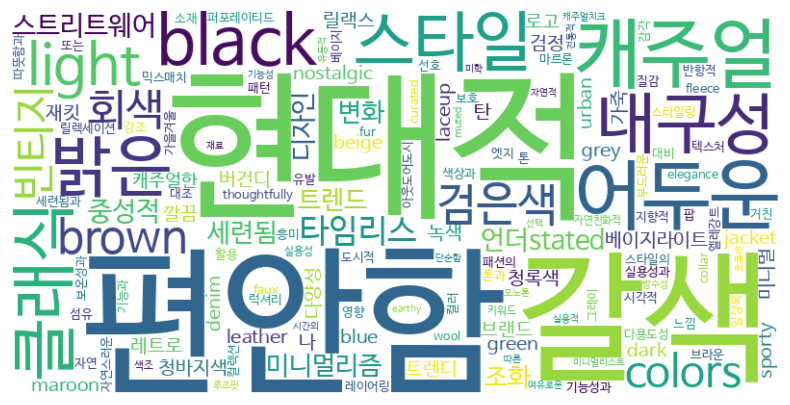

In [25]:
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def get_word_count(df):
    ## DataFrame의 'color'와 'keyword' 열에서 단어 빈도를 계산하는 함수
    if not df.empty:
        ## 'color' 열의 모든 단어를 리스트로 합침
        all_nouns = df['color'].apply(str.split).sum()
        ## 'keyword' 열의 모든 단어를 추가
        all_nouns += df['keyword'].apply(str.split).sum()
        ## '색상' 단어를 제외한 모든 단어를 필터링
        all_nouns = [word for word in all_nouns if word not in ['색상']]
        ## 단어 빈도를 Counter 객체로 반환
        return Counter(all_nouns)
    return Counter() ## DataFrame이 비어있으면 빈 Counter 반환

def create_wordcloud(word_count):
    ## 단어 빈도수를 기반으로 워드 클라우드를 생성하고 시각화하는 함수
    if not word_count: ## 단어 빈도가 없으면 워드클라우드 생성하지 않음
        print("No words to generate word cloud.")
        return

    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        colormap='viridis',
        font_path='/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf' ## 한글 폰트 경로 지정
        ).generate_from_frequencies(word_count)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off") ## 축 표시 제거
    plt.show() ## 워드 클라우드 출력

## DataFrame에서 단어 빈도 계산
word_count = get_word_count(df)
## 계산된 단어 빈도로 워드 클라우드 생성 및 시각화
create_wordcloud(word_count)

## 14-14 트렌드 분석 보고서 생성 프롬프트 구성 및 실행

## 14-15 분석 보고서 시각화

In [27]:
from vllm import SamplingParams ## SamplingParams 임포트가 필요

## 시스템 메시지로 시작하는 프롬프트 리스트 초기화
prompt = [
    {
        "role": "system",
        "content": "You are EXAONE model from LG AI Research, a helpful assistant."
    }
]
## DataFrame의 각 행을 순회하며 '스타일 노트'와 '이미지 URL'을 사용자 메시지로 추가
for row in df.itertuples():
  prompt.append({"role": "user", "content": f"스타일 노트: {row.style}\n이미지 url: {row.image}"}) # - 나~!
## 마지막으로, 종합적인 트렌드 분석 보고서 작성을 요청하는 사용자 메시지 추가
## 보고서 제목, 내용의 전문성, 마크다운 형식, 예시 이미지 포함을 지시
prompt.append({"role": "user", "content": "주어진 스타일 노트를 토대로 종합적인 트랜드 방향의 분석 보고서를 작성해주세요. 제목은 해외 룩북 스타일 분석입니다. 내용은 전문적이면서 명확하게 작성해주세요. 문서 형식은 markdown으로 만들어주세요."})# - 나~!

## 샘플링 파라미터 설정 (온도, top_p, 최대 토큰 수)
sampling_params = SamplingParams(temperature=0.2, top_p=0.95, max_tokens=4096)
## LLM 모델을 사용하여 구성된 프롬프트에 대한 응답 생성
result = llm.chat(prompt, sampling_params)[0].outputs[0].text

Processed prompts: 100%|██████████| 1/1 [00:18<00:00, 18.54s/it, est. speed input: 148.60 toks/s, output: 39.00 toks/s]


In [28]:
from IPython.display import display, Markdown

## LLM으로부터 생성된 결과(Markdown 형식의 보고서)를 Jupyter 환경에 표시
display(Markdown(result))

# 해외 룩북 스타일 분석 보고서

## 요약
본 보고서는 최근 여러 해외 패션 룩북에서 관찰되는 주요 스타일 트렌드를 종합적으로 분석하고, 이를 통해 현재 패션 산업의 방향성을 제시합니다. 주요 트렌드는 편안함, 기능성, 그리고 미니멀리즘에 중점을 두고 있으며, 다양한 시즌과 컨텍스트에 걸쳐 일관성을 보입니다.

## 트렌드 분석

### 1. **편안함과 기능성의 융합**
- **예시**: 
  - **이미지 1**: **Visvim** 컬렉션에서의 가죽 재킷과 스트라이프 셔츠 조합은 실용성과 스타일을 동시에 제공합니다.
  - **이미지 2**: **John Bull** 컬렉션의 베이지와 브라운 톤의 캐주얼한 코트와 바지는 일상 활동에 적합한 편안함을 강조합니다.
  - **이미지 3**: **Felmange** 컬렉션의 블랙 블레이저와 흰색 셔츠는 편안한 착용감과 고급스러움을 결합합니다.
  - **이미지 4**: **Nepenthes** 컬렉션의 브라운 재킷과 바지는 자연 친화적인 디자인과 편안함을 동시에 제공합니다.
  - **이미지 5**: **Robes Confection** 컬렉션의 브라운 재킷과 바지는 미니멀리즘과 편안함을 결합한 스타일을 보여줍니다.
  - **이미지 6**: **Nonnative** 컬렉션의 오버사이즈 블레이저와 바지는 활동성과 스타일을 동시에 추구합니다.
  - **이미지 7**: **Graphpaper** 컬렉션의 브라운 톤의 블레이저와 바지는 현대적인 미니멀리즘을 반영합니다.

### 2. **미니멀리즘과 기능성의 결합**
- **특징**:
  - **색상 팔레트**: 주로 중성적인 톤 (베이지, 그레이, 브라운 등)을 활용하여 시각적 균형을 이루고 있습니다.
  - **디자인 요소**: 간결한 라인과 패턴을 통해 고급스러움과 실용성을 동시에 추구합니다.
  - **소재**: 내구성이 뛰어난 소재 (가죽, 코튼 블렌드, 천연 섬유 등)를 선호하며, 때로는 물에 강한 소재를 사용하여 기능성을 강화합니다.

### 3. **지속 가능성과 전통의 조화**
- **예시**:
  - **Visvim**의 퍼 재킷은 전통적인 디자인 요소와 현대적인 기능성을 결합합니다.
  - **Nonnative**의 금속 Eyelets는 전통적인 디테일을 현대적으로 재해석한 사례입니다.

## 결론
현재 패션 트렌드는 편안함과 기능성을 중시하면서도 미니멀리즘과 고급스러움을 유지하려는 경향이 두드러집니다. 자연 친화적인 소재와 전통적인 디테일의 현대적 해석은 지속 가능성과 과거의 영감을 결합하여 새로운 방향성을 제시하고 있습니다. 이러한 트렌드는 다양한 활동과 상황에서 유연하게 활용될 수 있는 실용적인 의류 디자인을 선호하는 소비자들의 요구를 충족시키고 있습니다.

---

이 보고서는 패션 산업의 주요 트렌드를 분석하고, 이를 통해 미래의 디자인 방향성을 예측하는 데 도움을 주고자 작성되었습니다. 각 룩북의 특징적인 요소들이 어떻게 결합되어 현대 패션의 새로운 패러다임을 형성하고 있는지 명확히 보여줍니다.